In [1]:
# TIME GAN

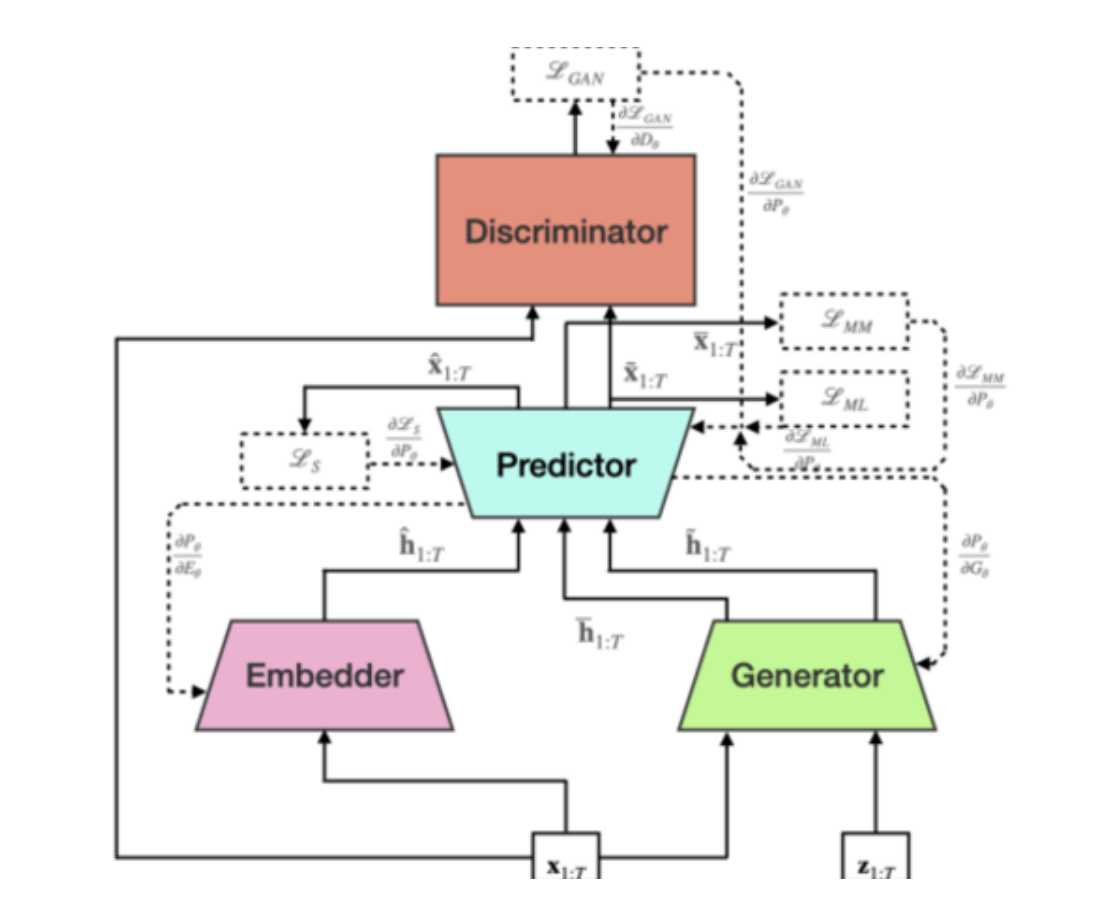

In [132]:
from IPython.display import Image
Image("Schema TsT-GAN.png", width=700, height=700)

In [134]:
import torch
from torch import nn
import numpy as np
from transformers import BertModel


'''
    Given that x[1:T] denotes a true time-series of length T and z[1:T] denotes a sequence of random vectors drawn from an isotropic Gaussian, we provide formal motivation for our model, with an accompanying block diagram in Figure 1.

    The embedder, trained using maximum likelihood estimation (MLE) takes as input x1:T and produces conditional latent embeddings hˆ[1:T] which the predictor maps to values xˆ1:T.

    The generator takes as input a sequence of random vectors z1:T and produces a corresponding set of latent embeddings h˜[1:T]. 
    To maximise the downstream utility of synthetic data, the generator aims to learn the conditional latent distribution produced by the embedder such that ph~. 
    We achieve this by sharing predictor parameters between the generator and discriminator, but allowing the predictor’s parameters to be changed only when updating with respect to the gradient ∂LS/∂Pθ , thereby forcing the condition.

    The discriminator is tasked with differentiating between real sequences x1:T and synthetic sequences x˜[1:T] . 
    The discriminator operates over entire sequences, producing only one true/false classification and so, inspects synthetic sequences on a global scale and encourages the generator to learn the joint distribution of entire sequences. 
    The objective LMM reinforces this by while also exposing the generator to real samples and further encouraging bidirectional learning of the joint distribution. 
    Some approaches to time-series generation have shown that explicit moment matching can improve the quality of synthetic data. We introduce an auxiliary moment loss to promote matching of first and second moments:
    
    where fµ and fσ are functions that compute the mean and standard deviation of a time-series.
    
    dim_val = 32
    hum_heads = 8
    hidden_dim = 4 * d = 128
    hum_layers = 3
    activation = GELU
    normalisation = LayerNorm
    
    optimisator = Adam
    LR1 = 0.001 for embedder-predictor and generator
    LR2 = 0.00002 
    beta1 = 0.5, beta2 = 0.999
    pmask = 0.3
    batch_size = 128
    
'''


class Embedder(nn.Module):
    '''
        The embedder–predictor network consists of a transformer network that takes as input real multivariate sequences x[1:T] and predicts the next item in the sequence at each position.
        This network consists of a linear projection of the input vector into the model dimension. 
        The projected sequence is passed through the embedder network Eθ to produce the set of final embeddings h[1:T]
        Эмбеддер формирует скрытые состояния и передает их на вход сети Предиктора. 
        Эмбеддер - дектодер трансформера
        Позиционное кодирование - синус ( заменить на тренируемое? )
        
        ??? Использует авторегрессионную маску ???
        
        Input: 
            x: real data B x S x F
                where B - Batch Size, S - sequence length, F - nums of features
        Output:
            out: hidden state B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension
        
        Loss: Ls = 1/T-1 * СУММА(||х[t+1] - x^t||2) - евклидово расстояние между реальными данными и прогнозом на t+1 шаг (torch.nn.PairwiseDistance(p=2))
    '''
    def __init__(self, device, input_dim, seq_len, hiden_dim, num_layers, num_heads, dim_feedforward):
        pass
        self.device = device
        self.input_dim = input_dim
        self.seq_len = seq_len
        self.hiden_dim = hiden_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        
        self.resize_F_H = nn.Linear(self.input_dim, self.hiden_dim)
        
        self.embedder_transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=self.hiden_dim, 
                                                                             nhead=self.num_heads, 
                                                                             dim_feedforward=self.dim_feedforward,
                                                                             activation='gelu', 
                                                                             device=self.device, 
                                                                             batch_first=True)
        self.embedder_transformer_decoder = nn.TransformerDecoder(decoder_layer = self.embedder_transformer_decoder_layer, 
                                                                  num_layers=self.num_layers, 
                                                                  norm=torch.nn.LayerNorm(normalized_shape=self.hiden_dim))
        
        self.src_mask = torch.triu(torch.ones((self.pred_len + 1, self.src_seq_len), 
                                              device=self.device) * float('-inf'), diagonal=1).to(torch.bool)
        self.tgt_mask = torch.triu(torch.ones((self.pred_len + 1, self.pred_len + 1), 
                                              device=self.device) * float('-inf'), diagonal=1).to(torch.bool)
    # Linear layer B x S x F -> B x S x H
    
    # TransformerDecoder  B x S x H ->  B x S x H
    def forward(self, x):
        pass

class Predictor(nn.Module):
    '''
        The predictor network Pθ takes the embeddings back into the original input dimension Pθ : Rd → R m and is implemented by a separate neural network.
        Предиктор получает от сети Эмбеддер скрытые состояния и предсказывает значения для t+1 шага для t[1:T] 
        Предиктор - простая линейная сеть, которая из размерности H переводит последовательность в размерность F
        
        Input: 
            x: latent space B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension embedder network
        Output:
            out: recovery real data B x S x F
                where B - Batch Size, S - sequence length, F - nums of features

        Loss: Ls = 1/T-1 * sum(||х[t+1] - x^t||2) - евклидово расстояние между реальными данными и прогнозом на t+1 шаг (torch.nn.PairwiseDistance(p=2))
            auxiliary loss:
                Lml = |mu(x) - mu(x~)| + |sigma(x) - sigma(x~)|
    '''
    # Linear layer B x S x H -> B x S x F
    pass

class Generator(nn.Module):
    '''
        The generator model Gθ takes a sequence of random vectors z[1:T] and projects these into the model dimension. 
        The projected noise vector is passed through Gθ which outputs a set of latent embeddings h[1:T]
        Each latent embedding h is then transformed back into the original input space by way of the predictor network from Section 3.2.1 to produce a synthetic sequence x˜[1:T]. 
        Parameters of the predictor network are shared between the generator and embedder.
        We construct Gθ in a similar way to the embedding network; it consists of a transformer encoder that makes use of bidirectional attention.
        To enforce the autoregressive property, we allow the parameters of the predictor network to be updated only when performing backpropagation through the embedder–predictor network. 
        When backpropagating through the generator-predictor network, gradients are calculated but the parameters of the predictor network are frozen. 
        This forces the generator to learn the latent conditional distributions of the embedder to produce valid synthetic data while also allowing full treatment of the joint probability. 
        The random vectors fed into the generator can be drawn from any distribution, we draw random vectors from a standard Gaussian distribution.
        
        Генератор из шума формирует последовтельность размерности скрытого состояния, прям как Эмбеддер, и отправляет в Предиктор. 
        При обновлении весов генератора Предиктор замораживается, что побуждает Генератор синтезировать корректные скрытые представления
        Позиционное кодирование - синус ( заменить на тренируемое? )

        ??? Генератор - энкодер трансформера ???
        ??? Генератор использует двунаправленное внимание ???
        
        ????? Генератор маскируется и попеременно обучается на максированных данных и исходных ?????
        
        Input: 
            x: noise B x S x Z
                where B - Batch Size, S - sequence length, Z - noise dimension
        Output:
            out: hidden state B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension
                
        Loss: Lgan(G) = min 1/2 (D(Xf) - 1) ^ 2 - MSE на фейковых данных и 1 как класс
            loss masking model:
              Lmm = 1/|M| sum (xt - x~t) ^ 2 - дополнительно MSE для максированных x последовательности
    '''
    # Linear layer B x S x Z -> B x S x H
    # TransformerEncoder BERTlike  B x S x H ->  B x S x H
    pass

class Discriminator(nn.Module):
    '''
       The discriminator model Dθ is constructed in a similar way to BERT as a transformer encoder with bidirectional attention. 
       A linear projection is used to map input sequences to the model dimension following which a [CLS] embedding is prepended to the beginning of the sequence. 
       This sequence is passed through the discriminator and the embedding corresponding to the [CLS] position is projected into R1 for classification. 
       The discriminator receives as input real sequences drawn from the dataset, which it is tasked with classifying as true, and synthetic sequences from the generator, which it must classify as false. 
       Our discriminator design focuses on a global classification of the quality of a sequence, which differs from previous RNN based approaches which classify on a per time step basis.
       By performing global sequence classification with the discriminator, we address our first objective in Equation 1, while the stepwise objective in Equation 2 is handled indirectly via the embedder–predictor system. 
       We apply the LS-GAN adversarial loss, which uses separate objectives for the discriminator and generator:
       
       Дискриминатор BERT like, при этом это энкодер трансформера с двунаправленным вниманием
       Позиционное кодирование - синус ( заменить на тренируемое? )
       
        
       Input: 
            x: noise B x S x Z
                where B - Batch Size, S - sequence length, Z - noise dimension
        Output:
            out: hidden state B x S x H
                where B - Batch Size, S - sequence length, H - hidden dimension
                   
        Loss: Lgan(D) = min((D(Xr)-1) ^ 2 + D(Xf) ^ 2)
    '''
    # Linear layer B x S x F -> B x S x H
    # TransformerEncoder BERTlike  B x S x H ->  B x S x H
    # Linear layer B x S x H -> B x 1
    pass

SyntaxError: invalid syntax (614193963.py, line 62)

In [ ]:
torch.triu(torch.ones((self.pred_len + 1, self.src_seq_len)) * float('-inf'), diagonal=1).to(torch.bool)criterion_S = nn.PairwiseDistance(p=2)
criterion_G = nn.MSELoss()
criterion_MM = nn.PairwiseDistance(p=2)
criterion_ML = nn.L1Loss()


optimizer_E = torch.optim.Adam()
optimizer_P = torch.optim.Adam()
optimizer_G = torch.optim.Adam()
optimizer_D = torch.optim.Adam()

In [ ]:
torch.triu(torch.ones((self.pred_len + 1, self.src_seq_len)) * float('-inf'), diagonal=1).to(torch.bool)criterion_S = nn.PairwiseDistance(p=2)
criterion_G = nn.MSELoss()
criterion_MM = nn.PairwiseDistance(p=2)
criterion_ML = nn.L1Loss()


optimizer_E = torch.optim.Adam()
optimizer_P = torch.optim.Adam()
optimizer_G = torch.optim.Adam()
optimizer_D = torch.optim.Adam()